# Model Haar interferometer with squeezed states, with training on differential particle number

We test the boson sampling operator 
on coherent states and squeezed states, and 
propagating in a random medium

We train the random medium to minimize <(n0-n1)^2> with a differential layer

A linear interferometer is used for training

Squeezing parameters are not trained

nonlinearxwaves@gmail.com<br>
@version 9 February 2021 <br>
@version 1 October 2023 <br>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages 

In [2]:
import numpy as np
from thqml import phasespace as ps
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools as it

In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [4]:
tf.keras.backend.clear_session()

In [5]:
#np.set_printoptions(precision=4)

Check GPU

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
import warnings
warnings.filterwarnings('ignore')

## Dimension

In [8]:
N = 12

In [9]:
n=np.floor_divide(N,2)

In [10]:
nmodes = int(n)

In [11]:
print('Number of modes '+repr(n))

Number of modes 6


## Build vacuum by the Gaussian state

In [12]:
vacuum = ps.VacuumLayer(N)

## Parameter for squeezing

In [13]:
r_np=0.88;
theta_np=np.pi/4;

## Random medium (Haar measure)

In [14]:
HAAR=ps.HaarLayerConstant(N)

In [15]:
R=ps.RandomLayer(N) # trainable layer

## Build the model (the squeezed states are not trainable)
squeezed states are generated and mixed by a random medium and then go into an Haar Inteferometer

In [16]:
xin = tf.keras.layers.Input(N)
x1, a1 = HAAR(xin)
x1, a1 = R(x1,a1)
for j in range(nmodes):
    x1, a1 = ps.SingleModeSqueezerLayer(N, r_np=r_np, theta_np=theta_np, n_squeezed=j, trainable=False)(x1,a1)
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

In [17]:
model.input_shape[1]

12

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 haar_layer_constant (HaarLayer  [(None, 12),        0           ['input_1[0][0]']                
 Constant)                       (12, 1)]                                                         
                                                                                                  
 random_layer (RandomLayer)     [(None, 12),         72          ['haar_layer_constant[0][0]',    
                                 (12, 1)]                         'haar_layer_constant[0][1]']    
                                                                                              

## Photon counting layer 

Dummy input

In [19]:
Nbatch=10
xtrain = np.random.rand(Nbatch, N)-0.5

Model with the photon counting layer

In [20]:
photon_counter=ps.PhotonCountingLayer(N) # define the layer
n_out = photon_counter(chir,chir, model);  # define the output tensor
Nphoton = tf.keras.Model(inputs = xin, outputs=n_out) # define the model with inputs and ouputs
tf.print(Nphoton(xtrain)); 

[[0.996120691 0.996120453 0.996120214 0.996120691 0.996121049 0.996120453]]


# Differential Gaussian Layer

In [21]:
Diff=ps.DifferentialGaussianLayer(N)
nboson, Dn, Dn2 = Diff(chir,chii, model)
HModel = tf.keras.Model(inputs = xin, outputs=[nboson,Dn2])

In [22]:
n_out,Dn_out=HModel(xtrain)
tf.print(Dn_out)

[[0 3.62751961 5.53536892 4.75839615 4.74084663 4.5266552]
 [3.62751961 0 5.38350105 2.98493 3.46787596 4.42038822]
 [5.53536892 5.38350105 0 5.33703136 6.13564539 5.59839]
 [4.75839615 2.98493 5.33703136 0 4.7537508 3.23938942]
 [4.74084663 3.46787596 6.13564539 4.7537508 0 4.94607353]
 [4.5266552 4.42038822 5.59839 3.23938942 4.94607353 0]]


Initial differential corrents

In [23]:
tf.gather_nd(Dn_out,[[0,1]])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.6275196], dtype=float32)>

Photon numbers before training

In [24]:
tf.print(n_out)

[[0.996120691 0.996120453 0.996120214 0.996120691 0.996121049 0.996120453]]


In [25]:
tf.reduce_mean(n_out)

<tf.Tensor: shape=(), dtype=float32, numpy=0.99612063>

In [26]:
tf.gather_nd(n_out,[[0,1]])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.99612045], dtype=float32)>

# Heisenberg Layer

In [27]:
Heis=ps.HeisenbergGaussianLayer(N)
nbosonH, nboson2, Dnboson2 = Heis(chir,chii, model)
HModel2 = tf.keras.Model(inputs = xin, outputs=[nbosonH, nboson2 , Dnboson2])

In [28]:
nHout,n2Hout,D2Hout=HModel2(xtrain)
tf.print(n2Hout)
tf.print(tf.gather_nd(n2Hout,[[0,0]]))

[[3.59051967 3.03975725 4.39071 3.23797202 3.73308897 3.51420403]]
[3.59051967]


## Model with the target output to train

Model with the custom ouput to train

In [29]:
Dn_out01=tf.gather_nd(Dn2,[[0,1]]) #check this
#n2_out0=tf.gather_nd(nboson2,[[0,0]])
#n2_out1=tf.gather_nd(nboson2,[[0,1]])
#train_out=tf.exp(-Dn_out01+n2_out0+n2_out1)
train_out=tf.exp(Dn_out01,name='Dn01')
nboson0=tf.gather_nd(nboson,[[0,0]], name='n0')
nboson1=tf.gather_nd(nboson,[[0,1]], name='n1')
Train_model = tf.keras.Model(inputs = xin, outputs=[train_out, nboson0, nboson1]) # define the model with inputs and ouputs

Define the custom loss to train the model for maximum output

In [30]:
def custom_loss(yt,yp):
    # the loss only return the output of the network yp
    # that need to be minimized
    return yp
Train_model.compile(loss=custom_loss, optimizer='Adam')

In [31]:
#Train_model.add_loss(train_out)
#Train_model.add_loss(nboson0)
#Train_model.add_loss(nboson1)
#Train_model.compile(optimizer='Adam')

# Transform model

In [32]:
kin, Qrho =ps.getQTransformModel(model)

In [33]:
Qrho.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 q_transform_layer (QTransfo  (None, None)             240       
 rmLayer)                                                        
                                                                 
Total params: 240
Trainable params: 72
Non-trainable params: 168
_________________________________________________________________


# Test the Pr operator 

Probability of zero photon

In [34]:
ps.Pr([0]*nmodes, Qrho)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.12573013]], dtype=float32)>

Probability of two photons

In [35]:
nbar = [0]*nmodes
nbar[0]=2
print(nbar)
ps.Pr(nbar, Qrho)

[2, 0, 0, 0, 0, 0]


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.00962241], dtype=float32)>

# Generate all the possible photon patterns assuming max one photon per mode

In [36]:
def patterns(nphotons, nmodes):
    # Return the patterns of nmodes with maximal nphotons
    
    # generate a list of zero
    l1=[0]*nmodes
    # set nphotons 1
    for j in range(nphotons):
        l1[j]=1
    # compute all the permutations (zeros and one are distinguishable)
    nlist=it.permutations(l1,nmodes) # return iterators
    # convert to list the iterators
    ln=list(nlist)
    # sort the list in reverse order to have the patterns with more ones first
    ln.sort(reverse=True)
    # remove duplicates (remove adjactent identical elements after sorting)
    ln=list(ln for ln,_ in it.groupby(ln))
    return ln

In [37]:
ln =patterns(2,nmodes)
print(ln)
print(len(ln))

[(1, 1, 0, 0, 0, 0), (1, 0, 1, 0, 0, 0), (1, 0, 0, 1, 0, 0), (1, 0, 0, 0, 1, 0), (1, 0, 0, 0, 0, 1), (0, 1, 1, 0, 0, 0), (0, 1, 0, 1, 0, 0), (0, 1, 0, 0, 1, 0), (0, 1, 0, 0, 0, 1), (0, 0, 1, 1, 0, 0), (0, 0, 1, 0, 1, 0), (0, 0, 1, 0, 0, 1), (0, 0, 0, 1, 1, 0), (0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 1, 1)]
15


## Make a plot versus the probability

Build an array of photon number sampling

In [38]:
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print('Computed by the neural network: '+repr(Pn[nbar]))
    print('--------------------')
    xaxis[nbar]=nbar #store for plot 
print('Done')

Sample 0 of 15 (1, 1, 0, 0, 0, 0)
Computed by the neural network: 0.016065268
--------------------
Sample 1 of 15 (1, 0, 1, 0, 0, 0)
Computed by the neural network: 0.007278896
--------------------
Sample 2 of 15 (1, 0, 0, 1, 0, 0)
Computed by the neural network: 0.0013502678
--------------------
Sample 3 of 15 (1, 0, 0, 0, 1, 0)
Computed by the neural network: 0.009438812
--------------------
Sample 4 of 15 (1, 0, 0, 0, 0, 1)
Computed by the neural network: 0.009364773
--------------------
Sample 5 of 15 (0, 1, 1, 0, 0, 0)
Computed by the neural network: 0.0009853698
--------------------
Sample 6 of 15 (0, 1, 0, 1, 0, 0)
Computed by the neural network: 0.020641364
--------------------
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
Computed by the neural network: 0.020833382
--------------------
Sample 8 of 15 (0, 1, 0, 0, 0, 1)
Computed by the neural network: 0.002351798
--------------------
Sample 9 of 15 (0, 0, 1, 1, 0, 0)
Computed by the neural network: 0.0048458427
--------------------
Sample 

Store data for plot

In [39]:
ln2u=ln
Pn2u=Pn

Plot

(0.0, 0.07)

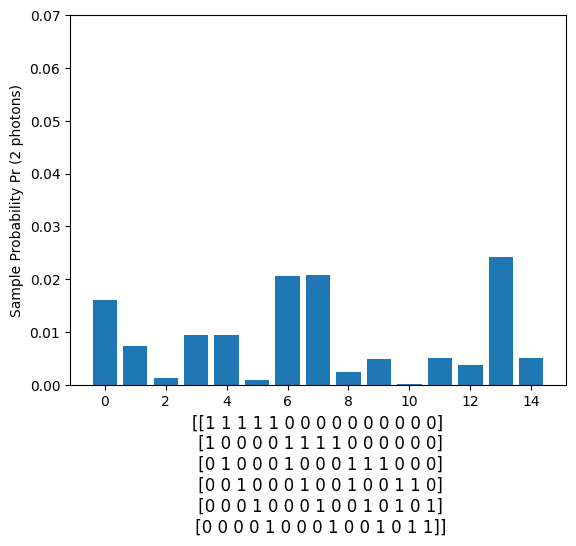

In [40]:
plt.bar(range(len(ln2u)),Pn2u)
plt.xlabel(np.transpose(np.array(ln2u)), fontsize=12);
plt.ylabel('Sample Probability Pr (2 photons)');
plt.ylim((0,0.07))

## Patterns with 4 photons

In [41]:
ln =patterns(4,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print('Computed by the neural network: '+repr(Pn[nbar]))
    print('--------------------')
    xaxis[nbar]=nbar #store for plot 
print('Done')


15
Sample 0 of 15 (1, 1, 1, 1, 0, 0)
Computed by the neural network: 0.00053540256
--------------------
Sample 1 of 15 (1, 1, 1, 0, 1, 0)
Computed by the neural network: 0.0006981875
--------------------
Sample 2 of 15 (1, 1, 1, 0, 0, 1)
Computed by the neural network: 0.0011331879
--------------------
Sample 3 of 15 (1, 1, 0, 1, 1, 0)
Computed by the neural network: 0.005340297
--------------------
Sample 4 of 15 (1, 1, 0, 1, 0, 1)
Computed by the neural network: 0.00097501394
--------------------
Sample 5 of 15 (1, 1, 0, 0, 1, 1)
Computed by the neural network: 0.005429069
--------------------
Sample 6 of 15 (1, 0, 1, 1, 1, 0)
Computed by the neural network: 7.012028e-05
--------------------
Sample 7 of 15 (1, 0, 1, 1, 0, 1)
Computed by the neural network: 0.0028711227
--------------------
Sample 8 of 15 (1, 0, 1, 0, 1, 1)
Computed by the neural network: 0.00074942154
--------------------
Sample 9 of 15 (1, 0, 0, 1, 1, 1)
Computed by the neural network: 0.0010197124
-----------------

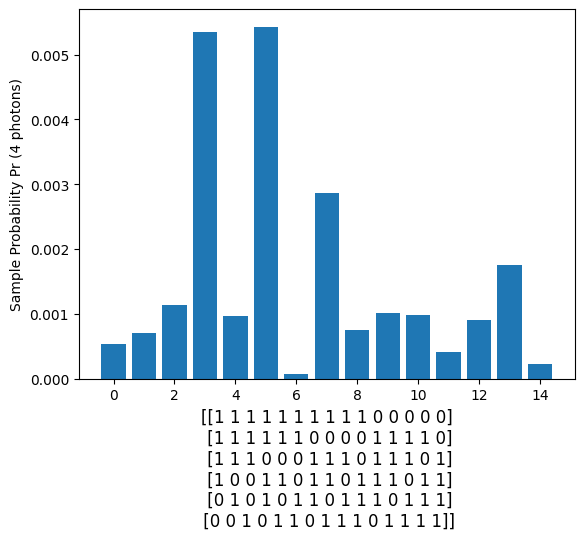

In [42]:
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr (4 photons)');

## Compute the probability of pairs 

In [43]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.12573012709617615 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.016065267845988274 pattern (1, 1, 0, 0, 0, 0)
Photons 2 Sample 2 of 15 Pr=0.007278895936906338 pattern (1, 0, 1, 0, 0, 0)
Photons 2 Sample 3 of 15 Pr=0.0013502677902579308 pattern (1, 0, 0, 1, 0, 0)
Photons 2 Sample 4 of 15 Pr=0.009438811801373959 pattern (1, 0, 0, 0, 1, 0)
Photons 2 Sample 5 of 15 Pr=0.009364772588014603 pattern (1, 0, 0, 0, 0, 1)
Photons 2 Sample 6 of 15 Pr=0.000985369784757495 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 7 of 15 Pr=0.02064136415719986 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 8 of 15 Pr=0.02083338238298893 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=0.0023517978843301535 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 10 of 15 Pr=0.004845842719078064 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 11 of 15 Pr=5.7431869208812714e-05 pattern (0, 0, 1, 0, 1, 0)


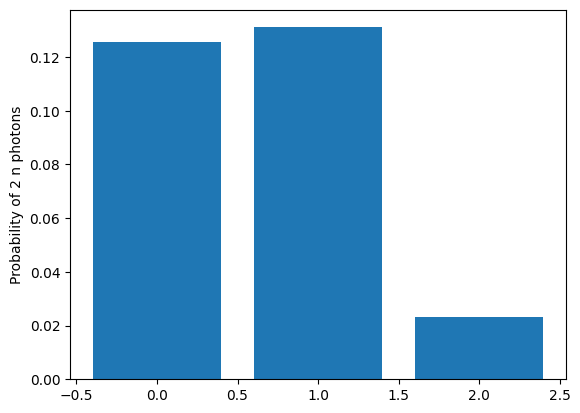

In [44]:
plt.bar(range(nmax+1),probn)
#plt.xlabel(ln, fontsize=6);
plt.ylabel('Probability of 2 n photons');

# Train the model and recompute probabilities

In [45]:
%%time
history=Train_model.fit(xtrain,np.zeros_like(xtrain),epochs=5000,verbose=0)

CPU times: user 1min 5s, sys: 2.02 s, total: 1min 7s
Wall time: 46.8 s


Plot training history

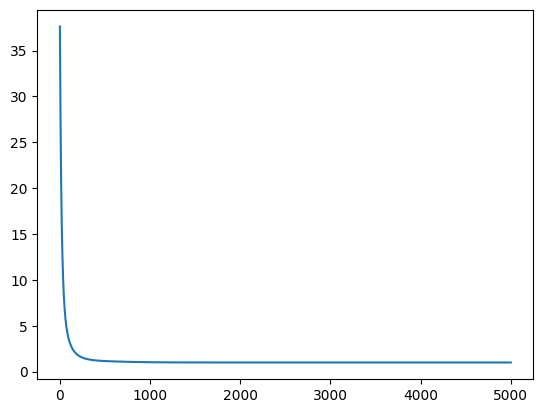

In [46]:
plt.plot(history.history['tf.math.exp_loss'])

Plot the training history in log scale (corresponding to Dn2_01, n0 and n1)

(0.0, 4.0)

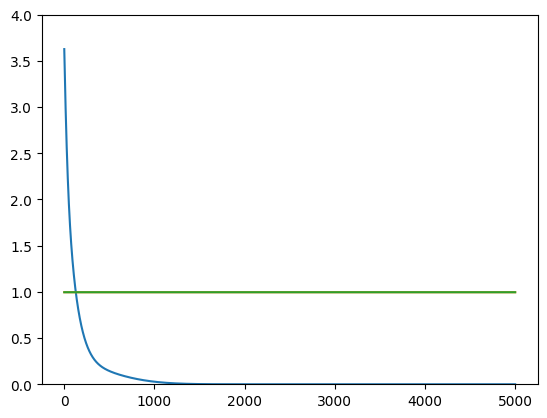

In [47]:
plt.plot(np.log(history.history['tf.math.exp_loss']))
plt.plot(history.history['tf.compat.v1.gather_nd_1_loss'])
plt.plot(history.history['tf.compat.v1.gather_nd_2_loss'])
plt.ylim((0,4.0))

Plot number of photons

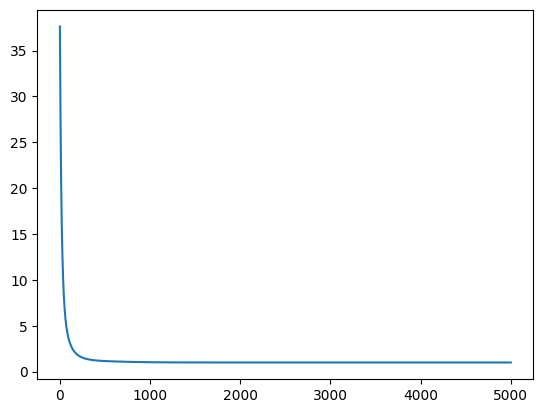

In [48]:
plt.plot(history.history['tf.math.exp_loss'])

## Photon number after training

In [49]:
tf.print(Nphoton(xtrain)); 

[[0.996120453 0.996120691 0.996120334 0.996120214 0.996120691 0.996120453]]


In [50]:
tf.reduce_mean(Nphoton(xtrain))

<tf.Tensor: shape=(), dtype=float32, numpy=0.99612045>

## Photon correlations after training

In [51]:
n_out,Dn_out=HModel(xtrain)
tf.print(Dn_out)
tf.print(tf.gather_nd(Dn_out,[0,1]))

[[0 0 5.84452868 4.49042034 5.81816626 4.50460196]
 [0 0 5.84452915 4.49042 5.81816578 4.50460243]
 [5.84452868 5.84452915 0 6.2811842 7.59839535 6.29573584]
 [4.49042034 4.49042 6.2811842 0 6.21464396 2.26305246]
 [5.81816626 5.81816578 7.59839535 6.21464396 0 6.25682068]
 [4.50460196 4.50460243 6.29573584 2.26305246 6.25682068 0]]
0


Important the mean photon number does not change in the modes!
But the difference between the number of photons is zero

## Recompute the transform

In [52]:
kin, Qrho =ps.getQTransformModel(model)
#QLayer = ps.TransformLayer(N, model)
#kin=tf.keras.layers.Input([N],dtype=model.dtype)
#Q = QLayer(kin)
#Qrho = tf.keras.Model(inputs=kin, outputs=Q)

## Patterns with 2 photons

In [53]:
ln =patterns(2,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print('Computed by the neural network: '+repr(Pn[nbar]))
    print('--------------------')
    xaxis[nbar]=nbar #store for plot 
print('Done')

15
Sample 0 of 15 (1, 1, 0, 0, 0, 0)
Computed by the neural network: 0.06274289
--------------------
Sample 1 of 15 (1, 0, 1, 0, 0, 0)
Computed by the neural network: -1.7763568e-15
--------------------
Sample 2 of 15 (1, 0, 0, 1, 0, 0)
Computed by the neural network: 2.4424907e-14
--------------------
Sample 3 of 15 (1, 0, 0, 0, 1, 0)
Computed by the neural network: 1.5099033e-14
--------------------
Sample 4 of 15 (1, 0, 0, 0, 0, 1)
Computed by the neural network: 3.5971226e-14
--------------------
Sample 5 of 15 (0, 1, 1, 0, 0, 0)
Computed by the neural network: -3.5527137e-15
--------------------
Sample 6 of 15 (0, 1, 0, 1, 0, 0)
Computed by the neural network: 4.3520743e-14
--------------------
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
Computed by the neural network: 1.9539925e-14
--------------------
Sample 8 of 15 (0, 1, 0, 0, 0, 1)
Computed by the neural network: 1.7763568e-14
--------------------
Sample 9 of 15 (0, 0, 1, 1, 0, 0)
Computed by the neural network: 0.0012150351
----------

In [54]:
ln2t=ln
Pn2t=Pn

(0.0, 0.07)

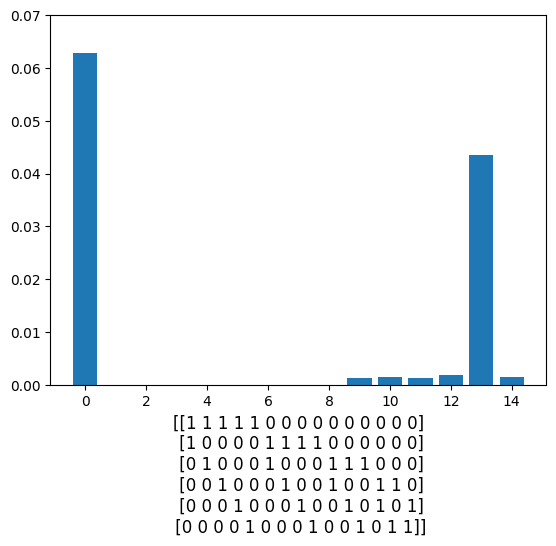

In [55]:
plt.bar(range(len(ln2t)),Pn2t)
plt.xlabel(np.transpose(np.array(ln2t)), fontsize=12);
plt.ylim((0,0.07))

## Patterns of 4 photons

In [56]:
ln =patterns(4,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print('Computed by the neural network: '+repr(Pn[nbar]))
    print('--------------------')
    xaxis[nbar]=nbar #store for plot 
print('Done')

15
Sample 0 of 15 (1, 1, 1, 1, 0, 0)
Computed by the neural network: 0.0006063455
--------------------
Sample 1 of 15 (1, 1, 1, 0, 1, 0)
Computed by the neural network: 0.0006892879
--------------------
Sample 2 of 15 (1, 1, 1, 0, 0, 1)
Computed by the neural network: 0.0006034379
--------------------
Sample 3 of 15 (1, 1, 0, 1, 1, 0)
Computed by the neural network: 0.00092268374
--------------------
Sample 4 of 15 (1, 1, 0, 1, 0, 1)
Computed by the neural network: 0.021692855
--------------------
Sample 5 of 15 (1, 1, 0, 0, 1, 1)
Computed by the neural network: 0.00070226775
--------------------
Sample 6 of 15 (1, 0, 1, 1, 1, 0)
Computed by the neural network: -4.6566068e-10
--------------------
Sample 7 of 15 (1, 0, 1, 1, 0, 1)
Computed by the neural network: -4.656607e-10
--------------------
Sample 8 of 15 (1, 0, 1, 0, 1, 1)
Computed by the neural network: 9.313234e-10
--------------------
Sample 9 of 15 (1, 0, 0, 1, 1, 1)
Computed by the neural network: 4.6566138e-09
-------------

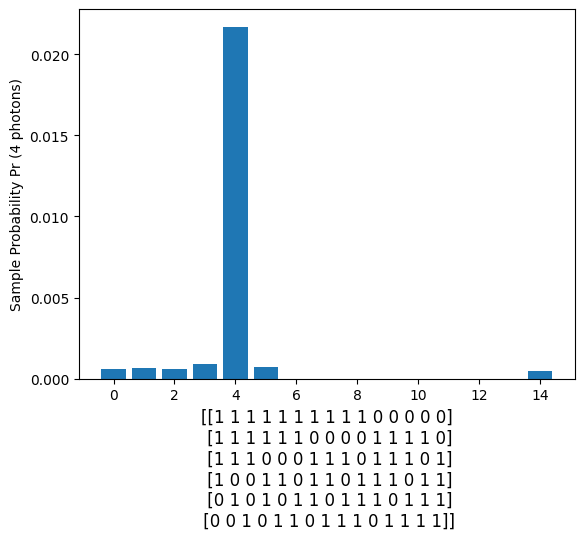

In [57]:
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.bar(range(npatterns),Pn)
plt.ylabel('Sample Probability Pr (4 photons)');

# Check the weights of layers

In [58]:
model.layers

In [59]:
for j in range(3,len(model.layers)-1):
    print('squeezer layer '+repr(j)+ ' r= '+repr(model.layers[j].r.numpy()) \
    + ' theta='+repr(model.layers[j].theta.numpy()))

squeezer layer 3 r= 0.88 theta=0.7853982
squeezer layer 4 r= 0.88 theta=0.7853982
squeezer layer 5 r= 0.88 theta=0.7853982
squeezer layer 6 r= 0.88 theta=0.7853982
squeezer layer 7 r= 0.88 theta=0.7853982
squeezer layer 8 r= 0.88 theta=0.7853982


In [60]:
tf.print(model.layers[9].d)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [61]:
tf.print(model.layers[2].get_M())

([[0.678030908 0.358566374 0.341942161 ... -0.165135458 0.240829512 0.0970078707]
 [-0.358566374 0.678030908 0.1134625 ... -0.0854827538 -0.0970078707 0.240829512]
 [-0.0273103863 -0.0845311359 0.650365412 ... 0.0172114689 -0.385653585 -0.0696014]
 ...
 [-0.103168398 0.243379653 0.114816606 ... 0.421908 0.144675702 0.0688650906]
 [-0.214171439 0.047563538 0.243638366 ... -0.382721186 0.693111062 -0.336526424]
 [-0.047563538 -0.214171439 0.0246342346 ... -0.0347716361 0.336526424 0.693111062]], [[0.678030908 -0.358566374 -0.0273103863 ... -0.103168398 -0.214171439 -0.047563538]
 [0.358566374 0.678030908 -0.0845311359 ... 0.243379653 0.047563538 -0.214171439]
 [0.341942161 0.1134625 0.650365412 ... 0.114816606 0.243638366 0.0246342346]
 ...
 [-0.165135458 -0.0854827538 0.0172114689 ... 0.421908 -0.382721186 -0.0347716361]
 [0.240829512 -0.0970078707 -0.385653585 ... 0.144675702 0.693111062 0.336526424]
 [0.0970078707 0.240829512 -0.0696014 ... 0.0688650906 -0.336526424 0.693111062]])


# Compute the statistical probability of pairs

In [62]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.12573020160198212 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.06274288892745972 pattern (1, 1, 0, 0, 0, 0)
Photons 2 Sample 2 of 15 Pr=-1.7763568394002505e-15 pattern (1, 0, 1, 0, 0, 0)
Photons 2 Sample 3 of 15 Pr=2.4424906541753444e-14 pattern (1, 0, 0, 1, 0, 0)
Photons 2 Sample 4 of 15 Pr=1.509903313490213e-14 pattern (1, 0, 0, 0, 1, 0)
Photons 2 Sample 5 of 15 Pr=3.597122599785507e-14 pattern (1, 0, 0, 0, 0, 1)
Photons 2 Sample 6 of 15 Pr=-3.552713678800501e-15 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 7 of 15 Pr=4.3520742565306136e-14 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 8 of 15 Pr=1.9539925233402755e-14 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=1.7763568394002505e-14 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 10 of 15 Pr=0.0012150350958108902 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 11 of 15 Pr=0.0013812491670250893 pattern (0, 0

In [63]:
probn

array([0.1257302 , 0.11327478, 0.02571868])

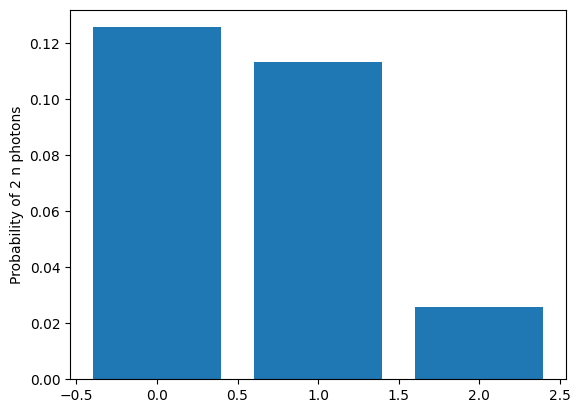

In [64]:
plt.bar(range(nmax+1),probn)
#plt.xlabel(ln, fontsize=6);
plt.ylabel('Probability of 2 n photons');

Looks that the overall probability does not change, but most of the couples appears in the target modes